# NLIP. Home assignment 2.                                  Zhanna Azizova

In [2]:
# load libraries

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import nltk
import re
import itertools

import sklearn.metrics as metrics

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate, train_test_split
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

## 1. Data preparation and analysis 

In [24]:
# reading the data 
data = pd.read_csv('SMSSpamCollection', sep='\t', names=["label", "sms"])

In [25]:
data.head(10) 

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [26]:
# check duplicates in our dataset
print("Number of all sms messages:", len(data))
print("Number of unique sms messages:",len(data['sms'].unique()))

Number of all sms messages: 5572
Number of unique sms messages: 5169


In [27]:
# drop duplicates
data = data.drop_duplicates('sms')

In [28]:
data.groupby('label').size() # The classes in the sample are clearly imbalanced

label
ham     4516
spam     653
dtype: int64

## 2. Metric for quality

The best choices as metrics for quality evaluation for the model are: **recall, precsicion and f1 score** for both classes.

Due to imbalance in the sample (in favour of ham messages) there is high chance to receive good metrics for class 0 (ham messages) prediction while metrics for class 1 (spam) detection might be not good enough. Therefore it is important to get classifier which perfectly separates classes 0 and 1. For this purpose accuracy is not representative metric and in the best scenario we should have equally high recall for each class. 

## 3. Data processing and feature extraction 

In [29]:
# encode labels to binary variable replace 
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

In [31]:
# make a fixed split into training and test samples
X_train, X_test, y_train, y_test = train_test_split(data['sms'], data['label'], test_size=0.2, random_state=43)

In [32]:
y_train.value_counts()

0    3626
1     509
Name: label, dtype: int64

In [33]:
y_test.value_counts()  # we have checked proportionality in sizes of the classes size after splitting the dataset

0    890
1    144
Name: label, dtype: int64

By using a sklearns count vectorizer method the messages in the dataset will be converted to a matrix, with each message being a row and each word(token) being the column, and the corresponding (row,column) values being the frequency of occurrence of each word or token in that sms message.

Algorithm for sklearns count vectorizer method:
* It tokenizes the string(separates the string into individual words) and gives an integer ID to each token.
* It counts the occurrence of each of those tokens.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual messages, in this case a column per text message. We will also concider removal of stop words from our messages.

In [34]:
count_vector = CountVectorizer(analyzer = 'word', stop_words='english', binary = False, ngram_range=(1, 2))

In [120]:
# For Sklearn NB model
X_train_counts = count_vector.fit_transform(X_train)
X_test_counts = count_vector.transform(X_test)

In [121]:
# Dataframes for self-made NB model
X_tr_df = pd.DataFrame(X_train_counts.toarray(), columns = count_vector.get_feature_names())
X_ts_df = pd.DataFrame(X_test_counts.toarray(), columns = count_vector.get_feature_names())

In [37]:
X_tr_df.shape, X_ts_df.shape # there are 31026 unique words (features) in our training dataset

((4135, 31026), (1034, 31026))

## 4. Naive bayes model training (by hand)

* $ P(ham | smsText) $ = Probability that sms is ham given that it contains content - smsText 

* $ P(spam | smsText) $  = Probability that sms is spam given that it contains content - smsText 

$$ P(ham | smsText) = \frac{P(ham) * P(smsText | ham)}{ P(smsText)} $$

$$ P(spam | smsText) = \frac{P(spam) * P(smsText | spam)}{P(smsText)} $$

$$ P(ham | smsText) = \frac{P(ham) * P(smsText | ham)}{P(smsText)} $$

$$ P(spam | smsText) = \frac{P(spam) * P(smsText | spam)}{P(smsText)} $$

Since P(smsText) is constant and common in both expressions, we can avoid it. 
$$ P(ham) = \frac{(number_of_messages_belonging_to_category_ham)}{total_N_of_messages} $$

$$ P(spam) = \frac{(number_of_messages_belonging_to_category_spam)}{total_N_of_messages} $$

To calculate the above two probabilities, we’ll use training Set table.

$$ P(smsText | spam) = P(word1 | spam) * P(word2 | spam) * … $$

$$ P(smsText | ham) = P(word1 | ham) * P(word2 | ham) * … $$

To calculate the above two probabilities, we’ll use wordFrequency table. Here word1, word2, word3 up to word-n are total words in smstext.

$$ P(word1 | spam) = \frac{count of word1 belonging to category spam}{total count of words belonging to category spam}.$$

$$ P(word1 | ham) = \frac{count of word1 belonging to category ham}{total count of words belonging to category ham}.$$

To solve this problem when the classifier detects a new word that is not present in training data sets, we will take log on both sides.

$$ log(P(ham | bodyText)) = log(P(ham)) + log(P(bodyText | ham)) = log(P(ham)) + log(P(word1 | ham)) + log(P(word2 | ham)) … $$

To solve the problem when a classifier encounters a new word that is not present in our training data sets, we’ll use Laplace smoothing. Now we’ll have-

$$ P(word1 | ham) = (count of word1 belonging to category ham + 1) / (total count of words belonging to ham + no of distinct words in training data sets) $$

$$ P(word1 | spam) = (count of word1 belonging to category spam + 1) / (total count of words belonging to spam + no of distinct words in training data sets) $$

In [308]:
def train_NB(X_train, y_train):
    count_vector = CountVectorizer(analyzer = 'word', stop_words='english', binary = False, ngram_range=(1, 2))
    
    X_train_counts = count_vector.fit_transform(X_train)
    
    X_train = pd.DataFrame(X_train_counts.toarray(), columns = count_vector.get_feature_names())
    
    P_ham = len(y_train[y_train == 0]) / len(y_train) # Probability that chosen message belongs to ham
    P_spam = len(y_train[y_train == 1]) / len(y_train) # Probability that chosen message belongs to spam
    
    classes_probs = [P_ham, P_spam]
    
    ham_data = X_train[X_train.index.isin(y_train[y_train == 0].index)]
    spam_data = X_train[X_train.index.isin(y_train[y_train == 1].index)]
    
    unique_words_in_train_data = X_train.shape[1]

    n_words_in_ham_data = np.array(ham_data).sum()
    n_words_in_spam_data = np.array(spam_data).sum()
    
    n_words = [n_words_in_ham_data + unique_words_in_train_data, n_words_in_spam_data + unique_words_in_train_data]

    words_frequences_for_ham = np.array(ham_data.sum())
    words_frequences_for_spam = np.array(spam_data.sum())
    
    return classes_probs, n_words, words_frequences_for_ham, words_frequences_for_spam  # return P(C) and P(Wi|C)

In [309]:
NB_classifier  = train_NB(X_train, y_train)

In [310]:
def NB_predict(model, X_test):
    
    X_test = count_vector.transform(X_test).toarray()
    
    pred = []
    
    classes_probs, n_words, words_frequences_for_ham, words_frequences_for_spam  = model
    
    for vec in X_test:
        freq_ham = vec * words_frequences_for_ham
        freq_ham = freq_ham[freq_ham > 0]
        prob_for_ham = np.log(classes_probs[0]) + (np.log((1 + freq_ham))/n_words[0]).sum() # add 1 to frequencies for Laplas smoothing purpose
        
        freq_spam = vec * words_frequences_for_spam
        freq_spam = freq_spam[freq_spam > 0]
        prob_for_spam = np.log(classes_probs[1]) + (np.log((1 + freq_spam))/n_words[1]).sum()

        if prob_for_spam > prob_for_ham:
            pred.append(1)
        else: 
            pred.append(0)
    
    result = pd.Series(pred, name = 'predicted')

    return result

## 3. Model testing

In [311]:
y_pred = NB_predict(NB_classifier, X_test)

In [312]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93       890
           1       0.00      0.00      0.00       144

   micro avg       0.86      0.86      0.86      1034
   macro avg       0.43      0.50      0.46      1034
weighted avg       0.74      0.86      0.80      1034



In [313]:
cm = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

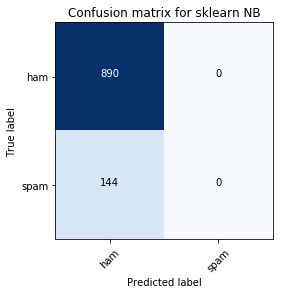

In [314]:
classes = ['ham', 'spam']
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix for sklearn NB')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Classifier doesnt detect spam at all

## 4. Comparing results with sklearn NB 

Specifically, we will be using the multinomial Naive Bayes implementation. This particular classifier is suitable for classification with discrete features (such as in our case, word counts for text classification). It takes in integer word counts as its input. On the other hand Gaussian Naive Bayes is better suited for continuous data as it assumes that the input data has a Gaussian(normal) distribution. 

In [213]:
skleran_NB = MultinomialNB()

MultinomialNB implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice). The distribution is parametrized by vectors 
$\theta_y = (\theta_{y1},\ldots,\theta_{yn})$
 for each class 
y
, where 
n
 is the number of features (in text classification, the size of the vocabulary) and $\theta_{yi}$
 is the probability $P(x_i \mid y)$
of feature *i*
 appearing in a sample belonging to class *y*.
The parameters $\theta_y$ is estimated by a smoothed version of maximum likelihood, i.e. relative frequency counting:
 
$$ \hat{\theta}_{yi} = \frac{ N_{yi} + \alpha}{N_y + \alpha n} $$
where 
$N_{yi} = \sum_{x \in T} x_i$
 is the number of times feature *i* appears in a sample of class *y* in the training set *T*, and $N_{y} = \sum_{i=1}^{n} N_{yi}$
 is the total count of all features for class *y*.
The smoothing priors 
α
≥
0
 accounts for features not present in the learning samples and prevents zero probabilities in further computations. Setting 
α
=
1
 is called Laplace smoothing, while 
α
<
1
 is called Lidstone smoothing.

In [214]:
# training the sklearn Naive Bayes model
skleran_NB.fit(X_train_counts, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [215]:
sk_learn_pred = skleran_NB.predict(X_test_counts)

In [216]:
print(classification_report(y_test, sk_learn_pred, target_names = ['ham','spam']))

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       890
        spam       0.99      0.94      0.96       144

   micro avg       0.99      0.99      0.99      1034
   macro avg       0.99      0.97      0.98      1034
weighted avg       0.99      0.99      0.99      1034



In [235]:
# perform 5-fold CV
scores = cross_validate(skleran_NB, X_test_counts, y_test, cv=5, scoring=('roc_auc'))
print("AUC scores", scores['test_score'].round(4))
    # with 95% confidence interval
print("AUC 95 prc confidence interval: %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

AUC scores [1.   0.96 0.97 0.97 0.99]
AUC 95 prc confidence interval: 0.98 (+/- 0.03)


In [223]:
cm = confusion_matrix(y_test,sk_learn_pred)
np.set_printoptions(precision=2)

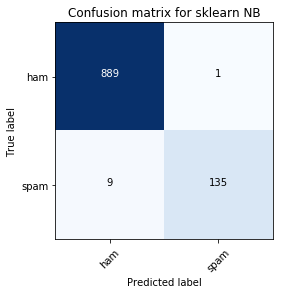

In [258]:
classes = ['ham', 'spam']
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix for sklearn NB')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

** As we can see, in this case the best algorithm for classification is sklearn Multinominal Naive Bayes **